<a href="https://colab.research.google.com/github/kacmanpolina/NN-project/blob/main/NN_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
# Импорт библиотек

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (roc_auc_score, classification_report,
                             confusion_matrix, accuracy_score, precision_recall_curve)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2
import warnings
warnings.filterwarnings('ignore')

In [53]:
# Загрузка данных

def load_data():
    url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"
    data = pd.read_csv(url)
    print("Данные успешно загружены")
    return data

data = load_data()

print(f"Размер датасета: {data.shape}")
print("\nПервые 5 строк:")
display(data.head())
print("\nРаспределение целевой переменной:")
print(data['Outcome'].value_counts())

Данные успешно загружены
Размер датасета: (768, 9)

Первые 5 строк:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1



Распределение целевой переменной:
Outcome
0    500
1    268
Name: count, dtype: int64


In [54]:
# Расширенная предобработка данных

def enhanced_preprocessing(data):

    data_clean = data.copy()


    medical_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

    # Обработка каждого медицинского показателя отдельно
    for column in medical_columns:
        # Разделяю обработку для пациентов с диабетом (Outcome=1) и без диабета (Outcome=0)
        for outcome in [0, 1]:
            mask = (data_clean[column] == 0) & (data_clean['Outcome'] == outcome)
            if mask.sum() > 0:
                # Вычисляю первый квартиль для ненулевых значений (он менее чуствителен к выбросам в отличие от медианы)
                # Заменяю нулевые значения на вычисленное значение
                q25 = data_clean[(data_clean[column] > 0) & (data_clean['Outcome'] == outcome)][column].quantile(0.25)
                data_clean.loc[mask, column] = q25

    # Создание новых признаков (позволяет выявить нелинейные зависимости между существующими признаками)

    # Отношение уровня глюкозы к индексу массы тела (может указывать на метаболическую эффективность)
    data_clean['Glucose_BMI_Ratio'] = data_clean['Glucose'] / (data_clean['BMI'] + 1e-8)

    # Отношение артериального давления к возрасту (учитывает возрастные изменения давления)
    data_clean['BP_Age_Ratio'] = data_clean['BloodPressure'] / (data_clean['Age'] + 1e-8)

    # Отношение инсулина к глюкозе (показатель инсулинорезистентности)
    data_clean['Insulin_Glucose_Ratio'] = data_clean['Insulin'] / (data_clean['Glucose'] + 1e-8)

    # Композитный показатель метаболического синдрома (три ключевых фактора риска)
    data_clean['Metabolic_Syndrome_Score'] = (
        data_clean['Glucose'] + data_clean['BMI'] + data_clean['BloodPressure']) / 3



    # Взаимодействия признаков (перемножение признаков для учета совместного влияния)

    # Уровень глюкозы и возраст (риск диабета возрастает с возрастом)
    data_clean['Glucose_Age_Interaction'] = data_clean['Glucose'] * data_clean['Age']

    # Индекс массы тела и наследственность диабета (генетика + фактор ожирения)
    data_clean['BMI_DPF_Interaction'] = data_clean['BMI'] * data_clean['DiabetesPedigreeFunction']

    # Количество беременностей и возраст (учитывает репродуктивный фактор (важно для женщин))
    data_clean['Pregnancy_Age_Interaction'] = data_clean['Pregnancies'] * data_clean['Age']



    # Полиномиальные признаки (квадраты исходных для учета нелинейности)

    # Уровень глюкозы (может выявлять нелинейные пороговые эффекты)
    data_clean['Glucose_squared'] = data_clean['Glucose'] ** 2

    # Индекс массы тела (учитывает, что риск растет непропорционально с ростом ИМТ)
    data_clean['BMI_squared'] = data_clean['BMI'] ** 2

    # Возраст (учитывает нелинейное влияние возраста на риск диабета)
    data_clean['Age_squared'] = data_clean['Age'] ** 2

    # Квадрат функции наследственности диабета
    data_clean['DPF_squared'] = data_clean['DiabetesPedigreeFunction'] ** 2



    # Логарифмические преобразования (нормализуют распределения с большими выбросами)
    data_clean['Insulin_log'] = np.log1p(data_clean['Insulin'])
    data_clean['DPF_log'] = np.log1p(data_clean['DiabetesPedigreeFunction'])

    # Вывод статистики по созданным признакам
    print(f"Создано {len([col for col in data_clean.columns if col not in data.columns])} новых признаков")
    print(f"Новый размер данных: {data_clean.shape}")

    return data_clean

# Применяю предобработку к исходным данным
data_enhanced = enhanced_preprocessing(data)

# Вывод новых признаков
print("Новые признаки:")
print([col for col in data_enhanced.columns if col not in data.columns])

Создано 13 новых признаков
Новый размер данных: (768, 22)
Новые признаки:
['Glucose_BMI_Ratio', 'BP_Age_Ratio', 'Insulin_Glucose_Ratio', 'Metabolic_Syndrome_Score', 'Glucose_Age_Interaction', 'BMI_DPF_Interaction', 'Pregnancy_Age_Interaction', 'Glucose_squared', 'BMI_squared', 'Age_squared', 'DPF_squared', 'Insulin_log', 'DPF_log']


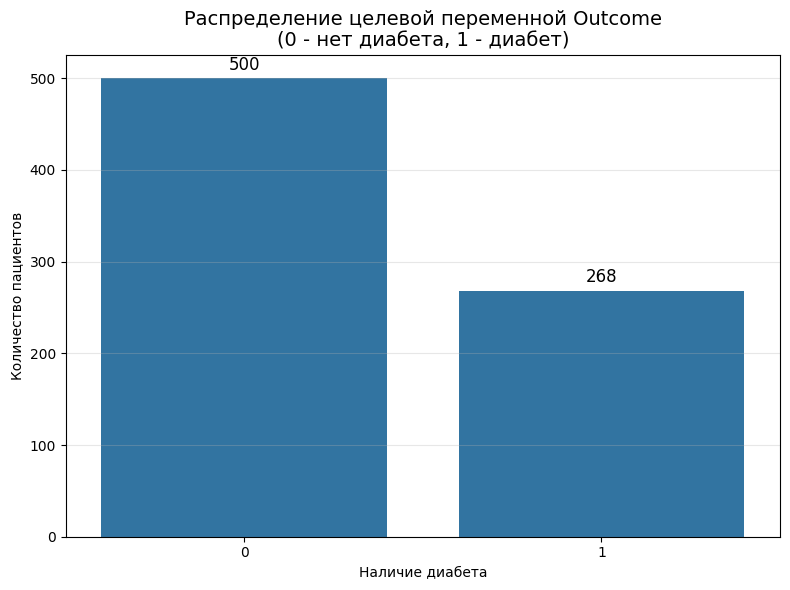

Статистика распределения целевой переменной:
Пациентов без диабета (0): 500 (65.1%)
Пациентов с диабетом (1): 268 (34.9%)




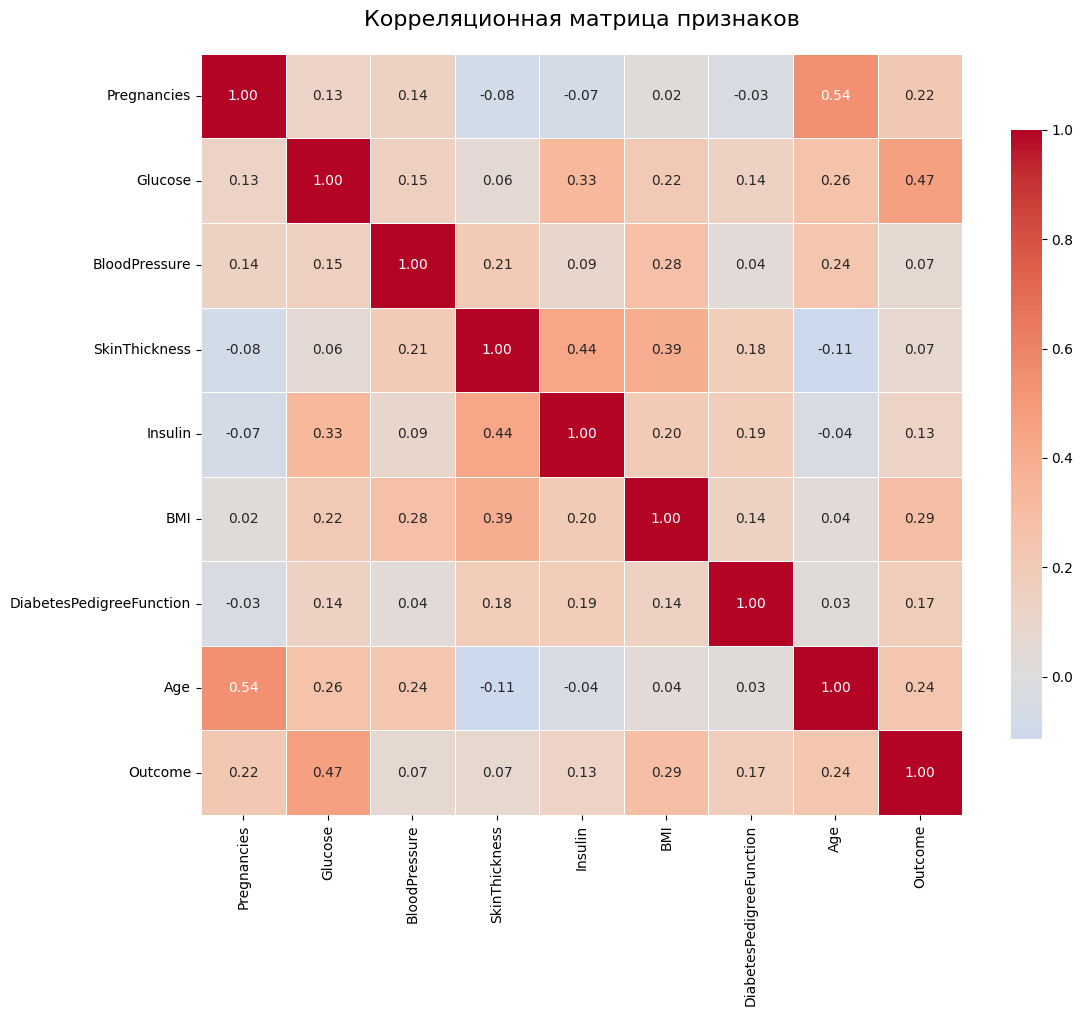


Корреляции признаков с целевой переменной Outcome (по убыванию):
Glucose: 0.467
BMI: 0.293
Age: 0.238
Pregnancies: 0.222
DiabetesPedigreeFunction: 0.174
Insulin: 0.131
SkinThickness: 0.075
BloodPressure: 0.065




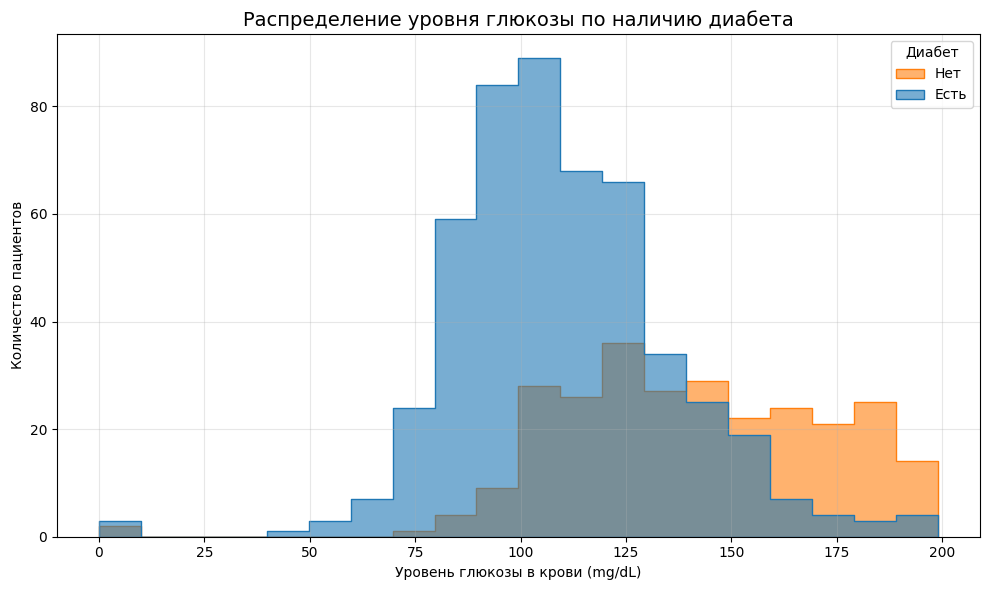

Статистика уровня глюкозы по группам:
          mean   std  min  max
Outcome                       
0        110.0  26.1    0  197
1        141.3  31.9    0  199




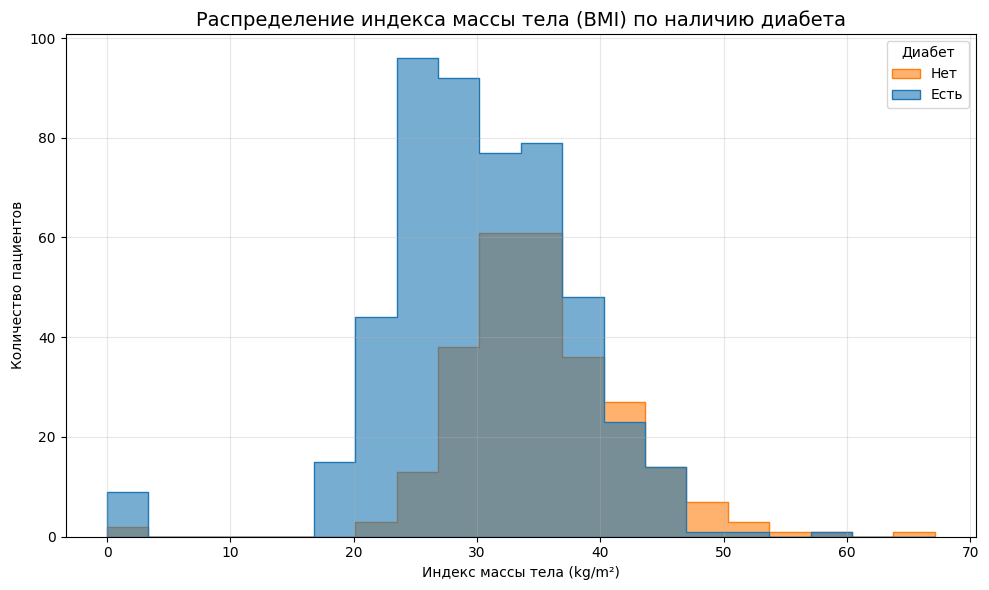

Статистика индекса массы тела по группам:
         mean  std  min   max
Outcome                      
0        30.3  7.7  0.0  57.3
1        35.1  7.3  0.0  67.1




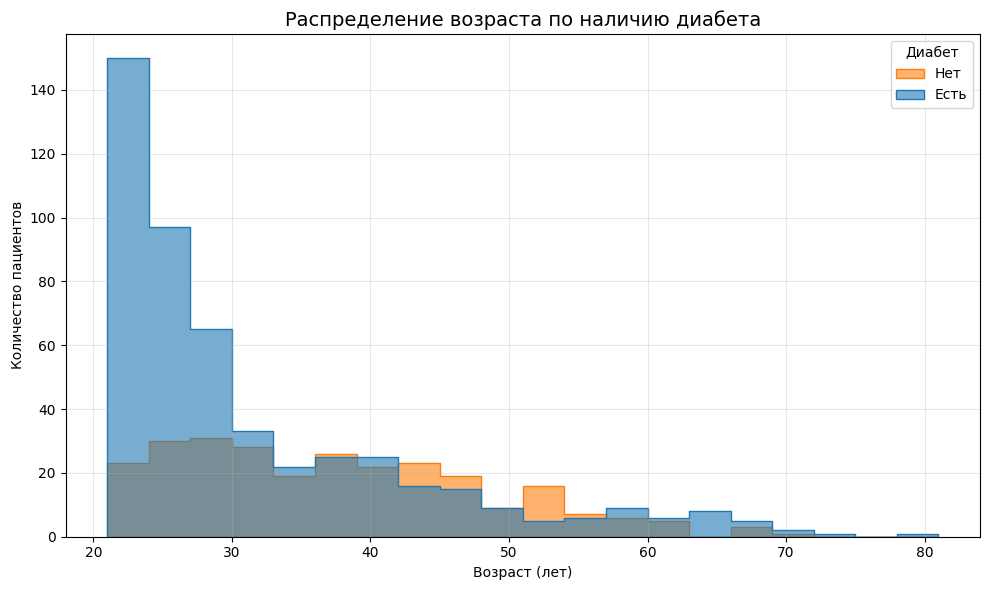

Статистика возраста по группам:
         mean   std  min  max
Outcome                      
0        31.2  11.7   21   81
1        37.1  11.0   21   70




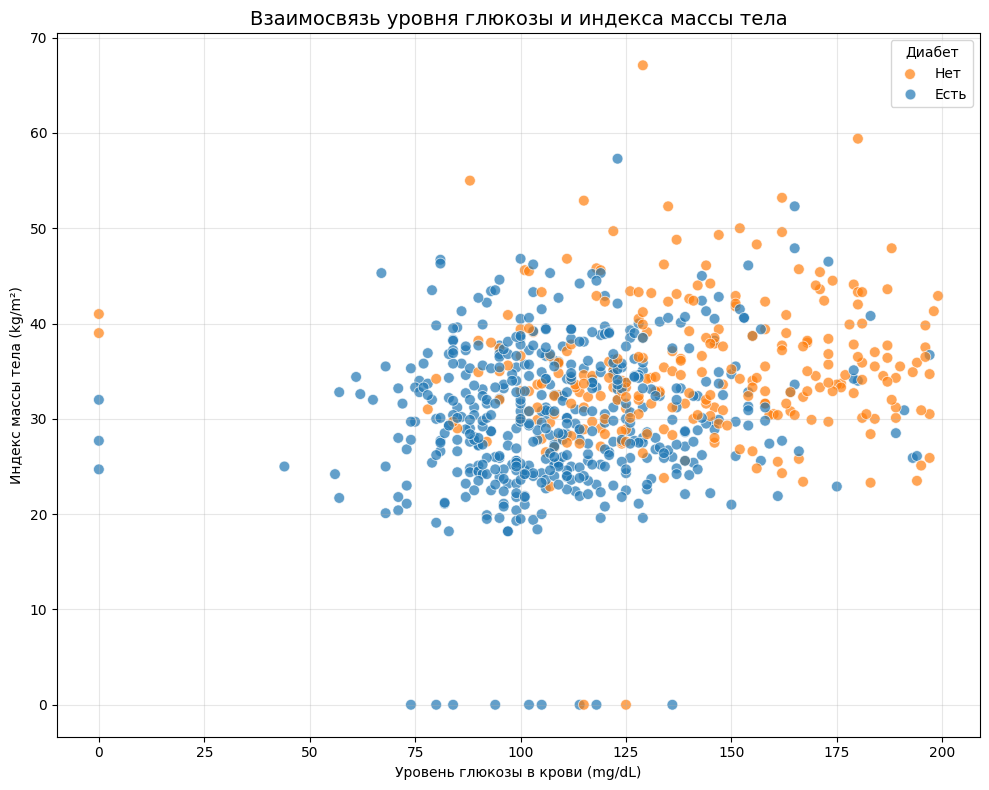

Анализ распределения пациентов по квадрантам (глюкоза > 126 и BMI > 25):
Доля пациентов с диабетом в каждом квадранте:
Глюкоза нормальная, BMI нормальный: 2.9%
Глюкоза нормальная, BMI высокий: 24.1%
Глюкоза высокая, BMI нормальный: 28.6%
Глюкоза высокая, BMI высокий: 62.9%




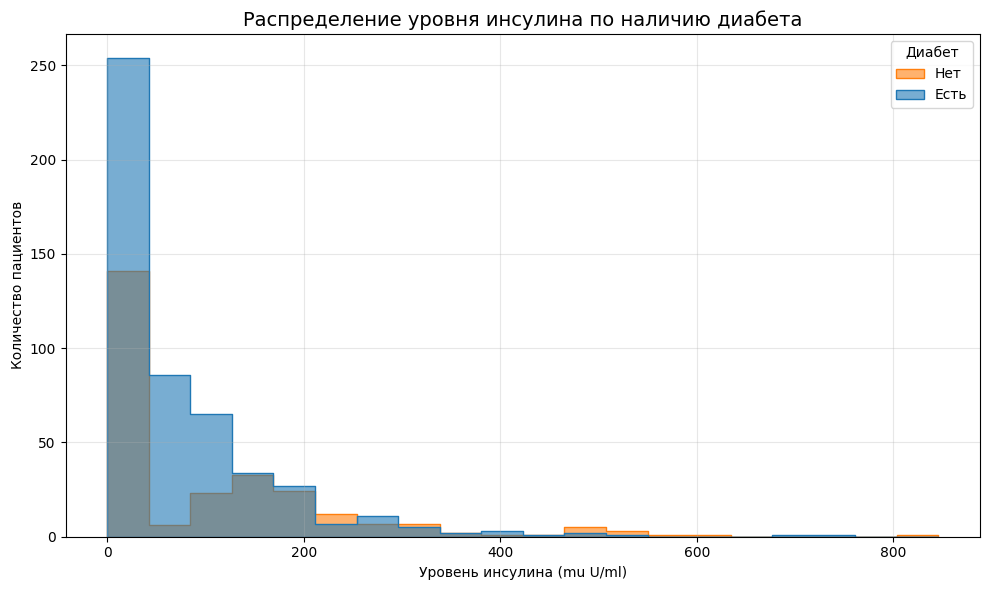

In [55]:
# Визуализация данных

# График 1: Распределение целевой переменной
def plot_target_distribution(data):
    # Визуализация распределения целевой переменной Outcome (показывает баланс между классами (диабет/нет диабета))
    plt.figure(figsize=(8, 6))

    # Столбчатая диаграмма для анализа баланса классов
    sns.countplot(data=data, x='Outcome')
    plt.title('Распределение целевой переменной Outcome\n(0 - нет диабета, 1 - диабет)', fontsize=14)
    plt.xlabel('Наличие диабета')
    plt.ylabel('Количество пациентов')

    # Подписи над столбцами
    for i, count in enumerate(data['Outcome'].value_counts().sort_index()):
        plt.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=12)

    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Вывод статистики
    print("Статистика распределения целевой переменной:")
    print(f"Пациентов без диабета (0): {data['Outcome'].value_counts()[0]} ({data['Outcome'].value_counts(normalize=True)[0]:.1%})")
    print(f"Пациентов с диабетом (1): {data['Outcome'].value_counts()[1]} ({data['Outcome'].value_counts(normalize=True)[1]:.1%})")

plot_target_distribution(data)

print('\n')


# График 2: Корреляционная матрица
def plot_correlation_matrix(data):
    # Визуализация корреляционной матрицы всех признаков (показывает линейные зависимости между переменными)
    plt.figure(figsize=(12, 10))

    # Вычисляю матрицу корреляций между всеми численными признаками
    correlation_matrix = data.corr()

    # Тепловая карта корреляций с аннотациями значений
    sns.heatmap(correlation_matrix,
                annot=True,           # Отображать численные значения
                fmt='.2f',            # Формат чисел (2 знака после запятой)
                cmap='coolwarm',      # Цветовая схема
                square=True,          # Квадратные ячейки
                center=0,            # Центр цветовой шкалы на 0
                cbar_kws={"shrink": .8},  # Настройки цветовой шкалы
                linewidths=0.5)       # Тонкие линии между ячейками

    plt.title('Корреляционная матрица признаков', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

    # Анализ корреляций с целевой переменной
    print("\nКорреляции признаков с целевой переменной Outcome (по убыванию):")
    outcome_correlations = correlation_matrix['Outcome'].sort_values(ascending=False)
    for feature, corr in outcome_correlations.items():
        if feature != 'Outcome':
            print(f"{feature}: {corr:.3f}")

plot_correlation_matrix(data)

print('\n')


# График  3: Распределение уровня глюкозы по классам
def plot_glucose_distribution(data):
    # Анализ распределения уровня глюкозы в крови для пациентов с диабетом и без (глюкоза - ключевой диагностический показатель диабета)
    plt.figure(figsize=(10, 6))

    # Гистограмма с наложением распределений для двух классов
    sns.histplot(data=data, x='Glucose', hue='Outcome', bins=20, alpha=0.6,
                 element='step',  # Контуры распределений
                 common_norm=False)  # Нормализация каждого распределения отдельно

    plt.title('Распределение уровня глюкозы по наличию диабета', fontsize=14)
    plt.xlabel('Уровень глюкозы в крови (mg/dL)')
    plt.ylabel('Количество пациентов')
    plt.legend(title='Диабет', labels=['Нет', 'Есть'])
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Статистика по глюкозе
    print("Статистика уровня глюкозы по группам:")
    glucose_stats = data.groupby('Outcome')['Glucose'].agg(['mean', 'std', 'min', 'max'])
    print(glucose_stats.round(1))

plot_glucose_distribution(data)

print('\n')


# График 4: Распределение индекса массы тела (BMI) по классам
def plot_bmi_distribution(data):
    # Анализ распределения индекса массы тела (BMI) (ожирение - важный фактор риска развития диабета 2 типа)
    plt.figure(figsize=(10, 6))

    # Гистограмма распределения BMI
    sns.histplot(data=data, x='BMI', hue='Outcome', bins=20, alpha=0.6,
                 element='step', common_norm=False)

    plt.title('Распределение индекса массы тела (BMI) по наличию диабета', fontsize=14)
    plt.xlabel('Индекс массы тела (kg/m²)')
    plt.ylabel('Количество пациентов')
    plt.legend(title='Диабет', labels=['Нет', 'Есть'])
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Статистика по BMI
    print("Статистика индекса массы тела по группам:")
    bmi_stats = data.groupby('Outcome')['BMI'].agg(['mean', 'std', 'min', 'max'])
    print(bmi_stats.round(1))

plot_bmi_distribution(data)

print('\n')


# График 5: Распределение возраста по классам
def plot_age_distribution(data):
    # Анализ распределения возраста пациентов(возраст является значимым фактором риска развития диабета 2 типа)
    plt.figure(figsize=(10, 6))

    # Гистограмма распределения возраста
    sns.histplot(data=data, x='Age', hue='Outcome', bins=20, alpha=0.6,
                 element='step', common_norm=False)

    plt.title('Распределение возраста по наличию диабета', fontsize=14)
    plt.xlabel('Возраст (лет)')
    plt.ylabel('Количество пациентов')
    plt.legend(title='Диабет', labels=['Нет', 'Есть'])
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Статистика по возрасту
    print("Статистика возраста по группам:")
    age_stats = data.groupby('Outcome')['Age'].agg(['mean', 'std', 'min', 'max'])
    print(age_stats.round(1))

plot_age_distribution(data)

print('\n')


# График 6: Диаграмма рассеяния Glucose vs BMI
def plot_glucose_bmi_scatter(data):
    # Диаграмма рассеяния для анализа взаимосвязи уровня глюкозы и индекса массы тела (показывает совместное влияние двух ключевых факторов риска)
    plt.figure(figsize=(10, 8))

    # Точечная диаграмма с разделением по классам
    scatter = sns.scatterplot(data=data, x='Glucose', y='BMI', hue='Outcome',
                             alpha=0.7, s=60)

    plt.title('Взаимосвязь уровня глюкозы и индекса массы тела', fontsize=14)
    plt.xlabel('Уровень глюкозы в крови (mg/dL)')
    plt.ylabel('Индекс массы тела (kg/m²)')
    plt.legend(title='Диабет', labels=['Нет', 'Есть'])
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Анализ распределения в квадрантах
    print("Анализ распределения пациентов по квадрантам (глюкоза > 126 и BMI > 25):")
    high_glucose = data['Glucose'] > 126  # Порог преддиабета
    high_bmi = data['BMI'] > 25           # Порог избыточного веса

    quadrant_stats = data.groupby([high_glucose, high_bmi])['Outcome'].mean()
    print("Доля пациентов с диабетом в каждом квадранте:")
    for (glucose_high, bmi_high), proportion in quadrant_stats.items():
        quadrant_name = f"Глюкоза {'высокая' if glucose_high else 'нормальная'}, BMI {'высокий' if bmi_high else 'нормальный'}"
        print(f"{quadrant_name}: {proportion:.1%}")

plot_glucose_bmi_scatter(data)

print('\n')


# График 7: Распределение инсулина
def plot_insulin_distribution(data):
    # Анализ распределения уровня инсулина (инсулин - важный гормон, связанный с диабетом)
    plt.figure(figsize=(10, 6))

    # Использую логарифмическую шкалу из-за большого разброса значений
    sns.histplot(data=data, x='Insulin', hue='Outcome', bins=20, alpha=0.6,
                 element='step', common_norm=False)

    plt.title('Распределение уровня инсулина по наличию диабета', fontsize=14)
    plt.xlabel('Уровень инсулина (mu U/ml)')
    plt.ylabel('Количество пациентов')
    plt.legend(title='Диабет', labels=['Нет', 'Есть'])
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_insulin_distribution(data)

In [56]:
# Подготовка данных для обучения

def prepare_data(data_enhanced):
    print("Подготовка данных для обучения")

    # Разделение на признаки и целевую переменную
    X = data_enhanced.drop("Outcome", axis=1) # Удаляю Outcome из матрицы признаков
    y = data_enhanced["Outcome"] # Сохраняю Outcome как целевую переменную

    print(f"Размер признаков: {X.shape}")
    print(f"Размер целевой переменной: {y.shape}")

    # Масштабирование с RobustScaler
    # RobustScaler менее чувствителен к выбросам по сравнению со StandardScaler
    # Он использует медиану и межквартильный размах вместо среднего и стандартного отклонения
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)

    # Разделение данных на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, # Масштабированные признаки
        y, # Целевая переменная
        test_size=0.15, # 15% данных для тестирования, 85% для обучения
        random_state=42, # Фиксирую random state для воспроизводимости результатов
        stratify=y # Гарантирует, что распределение классов в train и test будет таким же, как в исходных данных
        )

    # Вывод информации о разделенных данных
    print(f"Обучающая выборка: {X_train.shape[0]} samples")
    print(f"Тестовая выборка: {X_test.shape[0]} samples")
    print(f"Распределение классов в обучающей выборке: {np.bincount(y_train)}")
    print(f"Распределение классов в тестовой выборке: {np.bincount(y_test)}")


    # Балансировка классов
    class_weights = compute_class_weight(
        class_weight="balanced", # Автоматически вычисляет веса, обратно пропорциональные частотам классов
        classes=np.unique(y_train), # Уникальные классы в обучающих данных
        y=y_train # Целевые значения обучающей выборки
        )

    # Преобразование в словарь для использования в моделях
    class_weights = dict(enumerate(class_weights))

    print(f"Веса классов: {class_weights}")

    return X_train, X_test, y_train, y_test, scaler, class_weights

X_train, X_test, y_train, y_test, scaler, class_weights = prepare_data(data_enhanced)

Подготовка данных для обучения
Размер признаков: (768, 21)
Размер целевой переменной: (768,)
Обучающая выборка: 652 samples
Тестовая выборка: 116 samples
Распределение классов в обучающей выборке: [424 228]
Распределение классов в тестовой выборке: [76 40]
Веса классов: {0: np.float64(0.7688679245283019), 1: np.float64(1.4298245614035088)}


In [57]:
# Создание нейронной сети

def create_enhanced_model(input_dim):
    model = Sequential([
        # Первый слой с L1-L2 регуляризацией
        Dense(256, activation='relu', input_dim=input_dim,
              kernel_regularizer=l1_l2(l1=0.001, l2=0.001)), # L1-L2 регуляризация для борьбы с переобучением
        BatchNormalization(), # Нормализует выходы слоя, ускоряет обучение и стабилизирует процесс
        Dropout(0.6), # Высокий dropout - отключает 60% нейронов для сильной регуляризации

        # Второй слой
        Dense(128, activation='relu',
              kernel_regularizer=l1_l2(l1=0.001, l2=0.001)), # Продолжаю регуляризацию
        BatchNormalization(), # Нормализация после активации
        Dropout(0.5), # Уменьшаю dropout по мере углубления сети

        # Третий слой
        Dense(64, activation='relu',
              kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
        BatchNormalization(),
        Dropout(0.4),

        # Четвертый слой
        Dense(32, activation='relu',
              kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
        BatchNormalization(),
        Dropout(0.3),

        # Пятый слой
        Dense(16, activation='relu',
              kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
        BatchNormalization(),
        Dropout(0.2),

        # Выходной слой
        Dense(1, activation='sigmoid') # Sigmoid для бинарной классификации (вероятность диабета)
        ])

    # Компиляция модели
    model.compile(
        optimizer=Adam(learning_rate=0.0001), # Adam с маленьким learning rate для стабильного обучения
        loss='binary_crossentropy', # Функция потерь для бинарной классификации
        metrics=['accuracy', 'Precision', 'Recall']) # Метрики для мониторинга качества

    return model

# Создаю модель
input_dim = X_train.shape[1] # Количество признаков на входе (размерность данных)
nn_model = create_enhanced_model(input_dim)
print("Архитектура нейронной сети:")
nn_model.summary()

Архитектура нейронной сети:


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_44 (Dense)                │ (None, 256)            │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,393 (200.75 KB)

 Trainable params: 50,401 (196.88 KB)

 Non-trainable params: 992 (3.88 KB)

In [58]:
# Обучение нейронной сети с использованием техник оптимизации и колбэков для улучшения качества и стабильности обучения

def train_neural_network(model, X_train, y_train, X_test, y_test, class_weights):
    print("Обучение нейронной сети")

    # Колбэки (для мониторинга и управления процессом)
    callbacks = [
        # Ранняя остановка - предотвращает переобучение
        EarlyStopping(
            monitor='val_accuracy', # Мониторинг точность на валидационной выборке
            patience=25, # 25 эпох без улучшения перед остановкой
            restore_best_weights=True, # Восстанавление веса лучшей эпохи (не последней)
            mode='max', # Максимизация метрики (accuracy)
            verbose=1), # Вывод сообщений о срабатывании

        # Уменьшение learning rate при плато
        ReduceLROnPlateau(
            monitor='val_loss', # Мониторинг потери на валидации
            factor=0.5, # Уменьшение LR в 2 раза (новый LR = старый * 0.5)
            patience=15, # 15 эпох без улучшения
            min_lr=1e-7, # Минимальный learning rate
            verbose=1), # Вывод сообщений об изменении LR

        # Сохранение лучшей модели
        ModelCheckpoint(
            'best_nn_model.h5', # Имя файла для сохранения
            monitor='val_accuracy', # Сохранение при улучшении валидационной точности
            save_best_only=True, # Сохранение только лучшей модели
            mode='max', # Максимизация метрики
            verbose=1)] # Вывод сообщений о сохранении

    # Обучение модели
    history = model.fit(
        X_train, y_train, # Обучающие данные
        validation_data=(X_test, y_test), # Валидационные данные для мониторинга переобучения
        epochs=300, # Максимальное количество эпох
        batch_size=16, # Размер мини-батча
        class_weight=class_weights, # Веса классов для борьбы с несбалансированностью
        callbacks=callbacks, # Применение колбэков
        verbose=1, # Прогресс-бар и метрики
        shuffle=True) # Перемешивание данных перед каждой эпохой

    return history, model

# Обучение нейронной сети
nn_history, trained_nn_model = train_neural_network(
    nn_model, X_train, y_train, X_test, y_test, class_weights)

# Предсказания на тестовой выборке
nn_proba = trained_nn_model.predict(X_test, verbose=0).ravel() # .ravel() - преобразует массив в одномерный

nn_accuracy = accuracy_score(y_test, (nn_proba > 0.5).astype(int)) # Сравнение с порогом 0.5
print(f"Accuracy: {nn_accuracy:.4f}")

Обучение нейронной сети
Epoch 1/300
37/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.3162 - Recall: 0.4817 - accuracy: 0.4761 - loss: 4.8355
Epoch 1: val_accuracy improved from -inf to 0.64655, saving model to best_nn_model.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - Precision: 0.3181 - Recall: 0.4816 - accuracy: 0.4772 - loss: 4.8349 - val_Precision: 0.3333 - val_Recall: 0.0250 - val_accuracy: 0.6466 - val_loss: 4.5419 - learning_rate: 1.0000e-04
Epoch 2/300
32/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.3909 - Recall: 0.5334 - accuracy: 0.5366 - loss: 4.7293
Epoch 2: val_accuracy improved from 0.64655 to 0.66379, saving model to best_nn_model.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.3889 - Recall: 0.5321 - accuracy: 0.5371 - loss: 4.7236 - val_Precision: 1.0000 - val_Recall: 0.0250 - val_accuracy: 0.6638 - val_loss: 4.5213 - learning_rate: 1.0000e-04
Epoch 3/300
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.3626 - Recall: 0.5235 - accuracy: 0.5467 - loss: 4.6763
Epoch 3: val_accuracy did not improve from 0.66379
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.3642 - Recall: 0.5234 - accuracy: 0.5470 - loss: 4.6767 - val_Precision: 0.5000 - val_Recall: 0.0250 - val_accuracy: 0.6552 - val_loss: 4.5099 - learning_rate: 1.0000e-04
Epoch 4/300
34/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.3975 - Recall: 0.5428 - accuracy: 0.5303 - loss: 4.6845
Epoch 4: val_accuracy did not improve from 0.66379
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.3960 - Recall: 0.5451 - accuracy: 0.5321 - loss: 4.6834 - val_Precision: 0.3333 - val_Recall: 0.0250 - val_accuracy: 0.6466 - val_loss: 4.4974 - learn

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.4423 - Recall: 0.6236 - accuracy: 0.5976 - loss: 4.5354 - val_Precision: 0.5556 - val_Recall: 0.3750 - val_accuracy: 0.6810 - val_loss: 4.3451 - learning_rate: 1.0000e-04
Epoch 13/300
31/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.4320 - Recall: 0.5924 - accuracy: 0.6105 - loss: 4.4953
Epoch 13: val_accuracy did not improve from 0.68103
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.4330 - Recall: 0.5970 - accuracy: 0.6053 - loss: 4.5013 - val_Precision: 0.5517 - val_Recall: 0.4000 - val_accuracy: 0.6810 - val_loss: 4.3275 - learning_rate: 1.0000e-04
Epoch 14/300
33/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.4315 - Recall: 0.6313 - accuracy: 0.5948 - loss: 4.4996
Epoch 14: val_accuracy did not improve from 0.68103
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.4293 - Recall: 0.6213 - accuracy: 0.5902 - loss: 4.5083 - val_Precision: 0.5455 - val_Recall: 0.4500 - val_accuracy: 0.6810 - val_loss: 4.3104 - l

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.4217 - Recall: 0.6076 - accuracy: 0.5897 - loss: 4.5082 - val_Precision: 0.5526 - val_Recall: 0.5250 - val_accuracy: 0.6897 - val_loss: 4.2833 - learning_rate: 1.0000e-04
Epoch 17/300
33/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.4438 - Recall: 0.6413 - accuracy: 0.5970 - loss: 4.4977
Epoch 17: val_accuracy improved from 0.68966 to 0.73276, saving model to best_nn_model.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.4430 - Recall: 0.6327 - accuracy: 0.5956 - loss: 4.5025 - val_Precision: 0.6098 - val_Recall: 0.6250 - val_accuracy: 0.7328 - val_loss: 4.2716 - learning_rate: 1.0000e-04
Epoch 18/300
33/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.3940 - Recall: 0.5771 - accuracy: 0.5874 - loss: 4.4742
Epoch 18: val_accuracy did not improve from 0.73276
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.4110 - Recall: 0.5945 - accuracy: 0.5962 - loss: 4.4710 - val_Precision: 0.6000 - val_Recall: 0.6000 - val_accuracy: 0.7241 - val_loss: 4.2623 - learning_rate: 1.0000e-04
Epoch 19/300
33/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.4818 - Recall: 0.6287 - accuracy: 0.6333 - loss: 4.4586
Epoch 19: val_accuracy did not improve from 0.73276
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.4816 - Recall: 0.6319 - accuracy: 0.6342 - loss: 4.4534 - val_Precision: 0.6154 - val_Recall: 0.6000 - val_accuracy: 0.7328 - val_loss: 4.2524 - l

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.4342 - Recall: 0.5930 - accuracy: 0.5883 - loss: 4.4608 - val_Precision: 0.6136 - val_Recall: 0.6750 - val_accuracy: 0.7414 - val_loss: 4.2321 - learning_rate: 1.0000e-04
Epoch 22/300
34/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.4941 - Recall: 0.7642 - accuracy: 0.6771 - loss: 4.3627
Epoch 22: val_accuracy did not improve from 0.74138
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.4958 - Recall: 0.7516 - accuracy: 0.6731 - loss: 4.3690 - val_Precision: 0.6000 - val_Recall: 0.6750 - val_accuracy: 0.7328 - val_loss: 4.2231 - learning_rate: 1.0000e-04
Epoch 23/300
33/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.5377 - Recall: 0.7080 - accuracy: 0.6794 - loss: 4.3509
Epoch 23: val_accuracy improved from 0.74138 to 0.75000, saving model to best_nn_model.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.5371 - Recall: 0.7069 - accuracy: 0.6809 - loss: 4.3510 - val_Precision: 0.6170 - val_Recall: 0.7250 - val_accuracy: 0.7500 - val_loss: 4.2152 - learning_rate: 1.0000e-04
Epoch 24/300
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.5051 - Recall: 0.7021 - accuracy: 0.6512 - loss: 4.3674
Epoch 24: val_accuracy improved from 0.75000 to 0.75862, saving model to best_nn_model.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.5053 - Recall: 0.7019 - accuracy: 0.6515 - loss: 4.3674 - val_Precision: 0.6304 - val_Recall: 0.7250 - val_accuracy: 0.7586 - val_loss: 4.2101 - learning_rate: 1.0000e-04
Epoch 25/300
32/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.4971 - Recall: 0.7199 - accuracy: 0.6642 - loss: 4.3898
Epoch 25: val_accuracy did not improve from 0.75862
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.4986 - Recall: 0.7109 - accuracy: 0.6611 - loss: 4.3880 - val_Precision: 0.6304 - val_Recall: 0.7250 - val_accuracy: 0.7586 - val_loss: 4.1993 - learning_rate: 1.0000e-04
Epoch 26/300
33/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.5461 - Recall: 0.6949 - accuracy: 0.6850 - loss: 4.3261
Epoch 26: val_accuracy improved from 0.75862 to 0.76724, saving model to best_nn_model.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.5389 - Recall: 0.6940 - accuracy: 0.6802 - loss: 4.3329 - val_Precision: 0.6327 - val_Recall: 0.7750 - val_accuracy: 0.7672 - val_loss: 4.1916 - learning_rate: 1.0000e-04
Epoch 27/300
31/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.4938 - Recall: 0.6797 - accuracy: 0.6514 - loss: 4.3577
Epoch 27: val_accuracy did not improve from 0.76724
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.4962 - Recall: 0.6839 - accuracy: 0.6519 - loss: 4.3568 - val_Precision: 0.6275 - val_Recall: 0.8000 - val_accuracy: 0.7672 - val_loss: 4.1819 - learning_rate: 1.0000e-04
Epoch 28/300
37/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.5085 - Recall: 0.6534 - accuracy: 0.6459 - loss: 4.3496
Epoch 28: val_accuracy did not improve from 0.76724
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - Precision: 0.5082 - Recall: 0.6550 - accuracy: 0.6466 - loss: 4.3477 - val_Precision: 0.6275 - val_Recall: 0.8000 - val_accuracy: 0.7672 - val_loss: 4.1694 - 

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - Precision: 0.5004 - Recall: 0.6888 - accuracy: 0.6602 - loss: 4.3166 - val_Precision: 0.6400 - val_Recall: 0.8000 - val_accuracy: 0.7759 - val_loss: 4.1520 - learning_rate: 1.0000e-04
Epoch 31/300
37/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.5274 - Recall: 0.6941 - accuracy: 0.6575 - loss: 4.3245
Epoch 31: val_accuracy improved from 0.77586 to 0.78448, saving model to best_nn_model.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - Precision: 0.5242 - Recall: 0.6925 - accuracy: 0.6567 - loss: 4.3242 - val_Precision: 0.6471 - val_Recall: 0.8250 - val_accuracy: 0.7845 - val_loss: 4.1428 - learning_rate: 1.0000e-04
Epoch 32/300
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.5518 - Recall: 0.7101 - accuracy: 0.6844 - loss: 4.2852
Epoch 32: val_accuracy did not improve from 0.78448
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.5514 - Recall: 0.7111 - accuracy: 0.6844 - loss: 4.2847 - val_Precision: 0.6346 - val_Recall: 0.8250 - val_accuracy: 0.7759 - val_loss: 4.1353 - learning_rate: 1.0000e-04
Epoch 33/300
34/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.5610 - Recall: 0.7049 - accuracy: 0.6833 - loss: 4.2907
Epoch 33: val_accuracy did not improve from 0.78448
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.5516 - Recall: 0.7022 - accuracy: 0.6789 - loss: 4.2926 - val_Precision: 0.6346 - val_Recall: 0.8250 - val_accuracy: 0.7759 - val_loss: 4.1273 - 

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Precision: 0.5428 - Recall: 0.7087 - accuracy: 0.6771 - loss: 4.2252 - val_Precision: 0.6481 - val_Recall: 0.8750 - val_accuracy: 0.7931 - val_loss: 4.0995 - learning_rate: 1.0000e-04
Epoch 37/300
34/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.5925 - Recall: 0.7459 - accuracy: 0.6976 - loss: 4.2163
Epoch 37: val_accuracy did not improve from 0.79310
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.5834 - Recall: 0.7495 - accuracy: 0.6972 - loss: 4.2203 - val_Precision: 0.6481 - val_Recall: 0.8750 - val_accuracy: 0.7931 - val_loss: 4.0942 - learning_rate: 1.0000e-04
Epoch 38/300
31/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.5917 - Recall: 0.7040 - accuracy: 0.7128 - loss: 4.1806
Epoch 38: val_accuracy did not improve from 0.79310
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.5772 - Recall: 0.7000 - accuracy: 0.7049 - loss: 4.1849 - val_Precision: 0.6364 - val_Recall: 0.8750 - val_accuracy: 0.7845 - val_loss: 4.0832 - 

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.5451 - Recall: 0.8024 - accuracy: 0.7073 - loss: 4.0351 - val_Precision: 0.6491 - val_Recall: 0.9250 - val_accuracy: 0.8017 - val_loss: 3.9230 - learning_rate: 1.0000e-04
Epoch 57/300
34/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6008 - Recall: 0.8271 - accuracy: 0.7449 - loss: 4.0051
Epoch 57: val_accuracy did not improve from 0.80172
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.5977 - Recall: 0.8207 - accuracy: 0.7418 - loss: 4.0054 - val_Precision: 0.6379 - val_Recall: 0.9250 - val_accuracy: 0.7931 - val_loss: 3.9153 - learning_rate: 1.0000e-04
Epoch 58/300
34/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6031 - Recall: 0.6876 - accuracy: 0.7013 - loss: 4.0403
Epoch 58: val_accuracy did not improve from 0.80172
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.6000 - Recall: 0.7005 - accuracy: 0.7062 - loss: 4.0312 - val_Precision: 0.6271 - val_Recall: 0.9250 - val_accuracy: 0.7845 - val_loss: 3.9032 - l

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.6584 - Recall: 0.8353 - accuracy: 0.7799 - loss: 3.8305 - val_Precision: 0.6607 - val_Recall: 0.9250 - val_accuracy: 0.8103 - val_loss: 3.7487 - learning_rate: 1.0000e-04
Epoch 74/300
33/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6052 - Recall: 0.8514 - accuracy: 0.7635 - loss: 3.8320
Epoch 74: val_accuracy did not improve from 0.81034
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.6074 - Recall: 0.8440 - accuracy: 0.7620 - loss: 3.8329 - val_Precision: 0.6491 - val_Recall: 0.9250 - val_accuracy: 0.8017 - val_loss: 3.7416 - learning_rate: 1.0000e-04
Epoch 75/300
33/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.5589 - Recall: 0.8388 - accuracy: 0.7231 - loss: 3.8675
Epoch 75: val_accuracy did not improve from 0.81034
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.5657 - Recall: 0.8402 - accuracy: 0.7273 - loss: 3.8612 - val_Precision: 0.6491 - val_Recall: 0.9250 - val_accuracy: 0.8017 - val_loss: 3.7304 - l

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.6158 - Recall: 0.9051 - accuracy: 0.7951 - loss: 3.7127 - val_Precision: 0.6727 - val_Recall: 0.9250 - val_accuracy: 0.8190 - val_loss: 3.6324 - learning_rate: 1.0000e-04
Epoch 85/300
34/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6586 - Recall: 0.7639 - accuracy: 0.7455 - loss: 3.7641
Epoch 85: val_accuracy did not improve from 0.81897
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6495 - Recall: 0.7678 - accuracy: 0.7456 - loss: 3.7618 - val_Precision: 0.6607 - val_Recall: 0.9250 - val_accuracy: 0.8103 - val_loss: 3.6243 - learning_rate: 1.0000e-04
Epoch 86/300
33/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.5685 - Recall: 0.8321 - accuracy: 0.7464 - loss: 3.7038
Epoch 86: val_accuracy did not improve from 0.81897
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.5811 - Recall: 0.8334 - accuracy: 0.7515 - loss: 3.6983 - val_Precision: 0.6607 - val_Recall: 0.9250 - val_accuracy: 0.8103 - val_loss: 3.6134 - l

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.6290 - Recall: 0.8301 - accuracy: 0.7764 - loss: 3.4481 - val_Precision: 0.6852 - val_Recall: 0.9250 - val_accuracy: 0.8276 - val_loss: 3.3769 - learning_rate: 1.0000e-04
Epoch 108/300
38/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6175 - Recall: 0.8537 - accuracy: 0.7755 - loss: 3.4785
Epoch 108: val_accuracy did not improve from 0.82759
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.6216 - Recall: 0.8542 - accuracy: 0.7774 - loss: 3.4740 - val_Precision: 0.6727 - val_Recall: 0.9250 - val_accuracy: 0.8190 - val_loss: 3.3668 - learning_rate: 1.0000e-04
Epoch 109/300
34/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6663 - Recall: 0.8332 - accuracy: 0.7927 - loss: 3.4120
Epoch 109: val_accuracy did not improve from 0.82759
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.6634 - Recall: 0.8306 - accuracy: 0.7901 - loss: 3.4142 - val_Precision: 0.6727 - val_Recall: 0.9250 - val_accuracy: 0.8190 - val_loss: 3.3548

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.6410 - Recall: 0.9041 - accuracy: 0.7983 - loss: 3.2917 - val_Precision: 0.6981 - val_Recall: 0.9250 - val_accuracy: 0.8362 - val_loss: 3.2504 - learning_rate: 1.0000e-04
Epoch 119/300
33/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7031 - Recall: 0.8054 - accuracy: 0.7841 - loss: 3.3368
Epoch 119: val_accuracy improved from 0.83621 to 0.84483, saving model to best_nn_model.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.6884 - Recall: 0.8120 - accuracy: 0.7813 - loss: 3.3354 - val_Precision: 0.7037 - val_Recall: 0.9500 - val_accuracy: 0.8448 - val_loss: 3.2393 - learning_rate: 1.0000e-04
Epoch 120/300
38/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.5902 - Recall: 0.8040 - accuracy: 0.7566 - loss: 3.3742
Epoch 120: val_accuracy did not improve from 0.84483
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.5933 - Recall: 0.8040 - accuracy: 0.7571 - loss: 3.3710 - val_Precision: 0.6852 - val_Recall: 0.9250 - val_accuracy: 0.8276 - val_loss: 3.2278 - learning_rate: 1.0000e-04
Epoch 121/300
32/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6757 - Recall: 0.8631 - accuracy: 0.8048 - loss: 3.2575
Epoch 121: val_accuracy did not improve from 0.84483
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6719 - Recall: 0.8657 - accuracy: 0.8037 - loss: 3.2617 - val_Precision: 0.6852 - val_Recall: 0.9250 - val_accuracy: 0.8276 - val_loss: 3.2131

In [59]:
# Создание и обучение ансамбля разнородных моделей машинного обучения
# Ансамбль комбинирует сильные стороны разных алгоритмов для улучшения предсказаний

def create_ensemble_models(X_train, y_train, X_test, y_test):

    print("Создание ансамблевых моделей")

    # Random Forest - алгоритм бэггинга на основе решающих деревьев
    rf_model = RandomForestClassifier(
        n_estimators=300, # Большое количество деревьев для стабильности
        max_depth=15, # Ограничение глубины для предотвращения переобучения
        min_samples_split=3, # Минимальное количество samples для разделения узла
        min_samples_leaf=1, # Минимальное количество samples в листе
        max_features='sqrt', # Количество признаков для разделения = sqrt(n_features)
        bootstrap=True, # Случайные подвыборки
        random_state=42, # Фиксация случайности для воспроизводимости
        class_weight='balanced') # Автоматическая балансировка классов

    # Gradient Boosting - последовательное улучшение предсказаний
    gb_model = GradientBoostingClassifier(
        n_estimators=200, # Количество деревьев бустинга
        learning_rate=0.05, # Малый шаг обучения для плавной сходимости
        max_depth=8, # Меньшая глубина, чем у RF (бустинг более склонен к переобучению)
        min_samples_split=5, # Более строгие параметры для регуляризации
        min_samples_leaf=2,
        subsample=0.8, # Stochastic GB - использует 80% данных для каждого дер
        random_state=42) # Фиксация случайности для воспроизводимости

    # Support Vector Machine - работает хорошо в высокоразмерных пространствах
    svm_model = SVC(
        C=2.0, # Параметр регуляризации
        kernel='rbf', # Радиальная базисная функция для нелинейных разделений
        gamma='scale', # Автоматический подбор параметра ядра
        probability=True, # Включение расчета вероятностей (нужно для ансамбля)
        random_state=42, # Фиксация случайности для воспроизводимости
        class_weight='balanced') # Автоматическая балансировка классов

    # Logistic Regression - простая и интерпретируемая модель
    lr_model = LogisticRegression(
        C=1.0, # Параметр регуляризации
        penalty='l2', # L2 регуляризация (Ridge)
        solver='liblinear', # Алгоритм оптимизации для небольших датасетов
        random_state=42, # Фиксация случайности для воспроизводимости
        class_weight='balanced') # Автоматическая балансировка классов


    # Словарь моделей для удобного итеративного обучения
    models = {
        'Random Forest': rf_model,
        'Gradient Boosting': gb_model,
        'SVM': svm_model,
        'Logistic Regression': lr_model}

    # Словари для хранения результатов
    predictions = {} # Вероятности предсказаний каждой модели
    accuracies = {} # Accuracy каждой модели


    # Обучение и оценка каждой модели
    for name, model in models.items():
        print(f"\nОбучение {name}")
        model.fit(X_train, y_train) # Обучение модели на тренировочных данных

        # Получение вероятностей предсказаний
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test)[:, 1] # Вероятность класса 1 (диабет)
        else:
            y_pred_proba = model.decision_function(X_test)
            # Нормализация к диапазону [0, 1] для совместимости
            y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())

        # Бинарные предсказания (порог 0.5)
        y_pred = (y_pred_proba > 0.5).astype(int)
        accuracy = accuracy_score(y_test, y_pred)

        # Сохранение результатов
        predictions[name] = y_pred_proba
        accuracies[name] = accuracy
        print(f"{name} - Accuracy: {accuracy:.4f}")

    # Взвешенное усреднение (комбинирование моделей с учетом их качества)
    total_accuracy = sum(accuracies.values()) # Сумма всех accuracy
    weights = {name: acc/total_accuracy for name, acc in accuracies.items()} # Вес каждой модели пропорционален ее accuracy

    # Создание ансамблевого предсказания
    ensemble_proba = np.zeros_like(predictions['Random Forest']) # Инициализация нулями

    for name, proba in predictions.items():
        ensemble_proba += weights[name] * proba

    # Финальное предсказание ансамбля
    ensemble_pred = (ensemble_proba > 0.5).astype(int)
    ensemble_accuracy = accuracy_score(y_test, ensemble_pred)

    print(f"\nАнсамбль моделей - Accuracy: {ensemble_accuracy:.4f}")

    return ensemble_proba, ensemble_pred, ensemble_accuracy, accuracies

# Создание ансамбль
if data is not None:
    ensemble_proba, ensemble_pred, ensemble_accuracy, model_accuracies = create_ensemble_models(
        X_train, y_train, X_test, y_test)

Создание ансамблевых моделей

Обучение Random Forest
Random Forest - Accuracy: 0.8534

Обучение Gradient Boosting
Gradient Boosting - Accuracy: 0.8793

Обучение SVM
SVM - Accuracy: 0.8793

Обучение Logistic Regression
Logistic Regression - Accuracy: 0.8534

Ансамбль моделей - Accuracy: 0.8793


Комбинирование предсказаний

Веса: Нейросеть=0.490, Ансамбль=0.510
Комбинированная модель - Accuracy: 0.9052

Оптимизация порога классификации
Лучший порог: 0.450
Точность с лучшим порогом: 0.9138


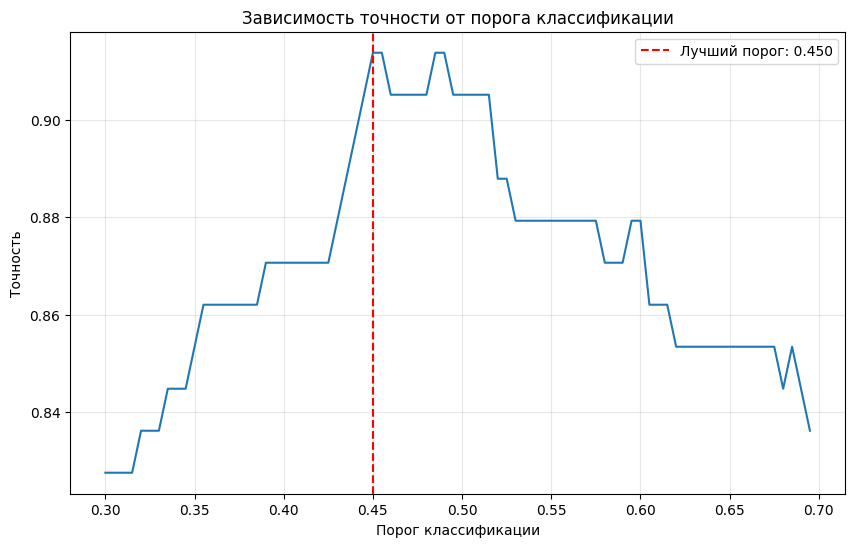

In [60]:
# Комбинирование предсказаний нейронной сети и ансамбля моделей с последующей оптимизацией порога классификации для максимизации точности

def combine_and_optimize(nn_proba, ensemble_proba, y_test, nn_accuracy, ensemble_accuracy):

    print("Комбинирование предсказаний")

    # Взвешивание на основе точности
    # Модель с большей точностью получает больший вес в финальном предсказании
    nn_weight = nn_accuracy / (nn_accuracy + ensemble_accuracy)
    ensemble_weight = ensemble_accuracy / (nn_accuracy + ensemble_accuracy)

    print(f"\nВеса: Нейросеть={nn_weight:.3f}, Ансамбль={ensemble_weight:.3f}")

    # Комбинирование вероятностей: взвешенная сумма предсказаний
    combined_proba = (nn_weight * nn_proba + ensemble_weight * ensemble_proba)

    # Оценка точности комбинированной модели с порогом по умолчанию (0.5)
    combined_accuracy = accuracy_score(y_test, (combined_proba > 0.5).astype(int))
    print(f"Комбинированная модель - Accuracy: {combined_accuracy:.4f}")

    # Оптимизация порога классификации
    print("\nОптимизация порога классификации")

    # Создание диапазона порогов для тестирования
    thresholds = np.arange(0.3, 0.7, 0.005) # От 0.3 до 0.7 с шагом 0.005
    best_threshold = 0.5 # Начальное значение лучшего порога
    best_accuracy = 0 # Начальное значение лучшей точности

    accuracies = [] # Список для хранения точностей при разных порогах

    # Перебор всех порогов для поиска оптимального
    for threshold in thresholds:
        # Применение текущего порога для бинарной классификации
        y_pred = (combined_proba > threshold).astype(int)
        # Вычисление точности с текущим порогом
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        # Обновление лучшего порога, если найдена более высокая точность
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold

    print(f"Лучший порог: {best_threshold:.3f}")
    print(f"Точность с лучшим порогом: {best_accuracy:.4f}")


    # Визуализация
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, accuracies)
    plt.axvline(best_threshold, color='red', linestyle='--', label=f'Лучший порог: {best_threshold:.3f}')
    plt.xlabel('Порог классификации')
    plt.ylabel('Точность')
    plt.title('Зависимость точности от порога классификации')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return combined_proba, best_threshold, best_accuracy

if data is not None:
    combined_proba, best_threshold, best_accuracy = combine_and_optimize(
        nn_proba, ensemble_proba, y_test, nn_accuracy, ensemble_accuracy)

In [61]:
# Применение SMOTE (Synthetic Minority Over-sampling Technique) для улучшения результатов

def apply_smote_technique(data_enhanced):

    print("\nПрименение SMOTE для балансировки данных")

    try:
        from imblearn.over_sampling import SMOTE

        # Подготовка данных
        X = data_enhanced.drop("Outcome", axis=1)
        y = data_enhanced["Outcome"]

        print(f"\nИсходные данные: {X.shape}")
        print(f"Исходное распределение: {np.bincount(y)}")

        # Применнение SMOTE для балансировки классов
        smote = SMOTE(random_state=42, # Фиксация случайности для воспроизводимости
                      k_neighbors=3) # Количество ближайших соседей для генерации
        X_balanced, y_balanced = smote.fit_resample(X, y)  # fit_resample создает синтетические примеры минорного класса

        print(f"\nДанные после SMOTE: {X_balanced.shape}")
        print(f"Сбалансированное распределение: {np.bincount(y_balanced)}")

        return X_balanced, y_balanced

    except ImportError:
        print("\nSMOTE не установлен. Установите: !pip install imbalanced-learn")
        return None, None

# Функция для обучения на сбалансированных данных, полученных с помощью SMOTE
def train_on_balanced_data(X_balanced, y_balanced):

    print("\nПодготовка сбалансированных данных")

    # Масштабирование признаков
    scaler_balanced = RobustScaler()
    X_scaled_balanced = scaler_balanced.fit_transform(X_balanced)

    # Разделение на обучающую и тестовую выборки
    # Стратификация важна даже для сбалансированных данных
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
        X_scaled_balanced, y_balanced,
        test_size=0.15,
        random_state=42,
        stratify=y_balanced)

    print(f"\nОбучающая выборка: {X_train_bal.shape[0]}")
    print(f"Тестовая выборка: {X_test_bal.shape[0]}\n")

    # Создание и обучение модели на сбалансированных данных
    input_dim_bal = X_train_bal.shape[1]
    model_balanced = create_enhanced_model(input_dim_bal)

    # Обучение без весов классов (данные уже сбалансированы)
     # class_weight=None, так как SMOTE уже решил проблему несбалансированности
    history_balanced, trained_model_balanced = train_neural_network(
        model_balanced, X_train_bal, y_train_bal, X_test_bal, y_test_bal, None)

    # Предсказания на тестовой выборке
    y_proba_balanced = trained_model_balanced.predict(X_test_bal, verbose=0).ravel()

    # Оптимизация порога классификации для сбалансированных данных
    thresholds = np.arange(0.3, 0.7, 0.005)
    best_threshold_bal = 0.5
    best_accuracy_bal = 0

    for threshold in thresholds:
        y_pred = (y_proba_balanced > threshold).astype(int)
        accuracy = accuracy_score(y_test_bal, y_pred)
        if accuracy > best_accuracy_bal:
            best_accuracy_bal = accuracy
            best_threshold_bal = threshold

    print(f"\nЛучший порог после SMOTE: {best_threshold_bal:.3f}")
    print(f"Точность после SMOTE: {best_accuracy_bal:.4f}")

    return best_accuracy_bal, best_threshold_bal

# Применение SMOTE если точность ниже 90%
if data is not None and best_accuracy < 0.9:
    X_balanced, y_balanced = apply_smote_technique(data_enhanced)

    if X_balanced is not None:
        # Обучение на сбалансированных данных
        smote_accuracy, smote_threshold = train_on_balanced_data(X_balanced, y_balanced)
        final_accuracy = smote_accuracy
    else:
        # Если SMOTE не сработал, использование предыдущей точности
        final_accuracy = best_accuracy
else:
    # Если точность уже высокая, SMOTE не применяется
    final_accuracy = best_accuracy

print(f"\nФинальная точность: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")


Финальная точность: 0.9138 (91.38%)


Финальная оценка результатов

Сравнительная таблица всех моделей
                Модель  Точность
0       Нейронная сеть    0.8448
1          Ансамбль ML    0.8793
2        Random Forest    0.8534
3    Gradient Boosting    0.8793
4                  SVM    0.8793
5  Logistic Regression    0.8534
6      Комбинированная    0.9138
7            Финальная    0.9138




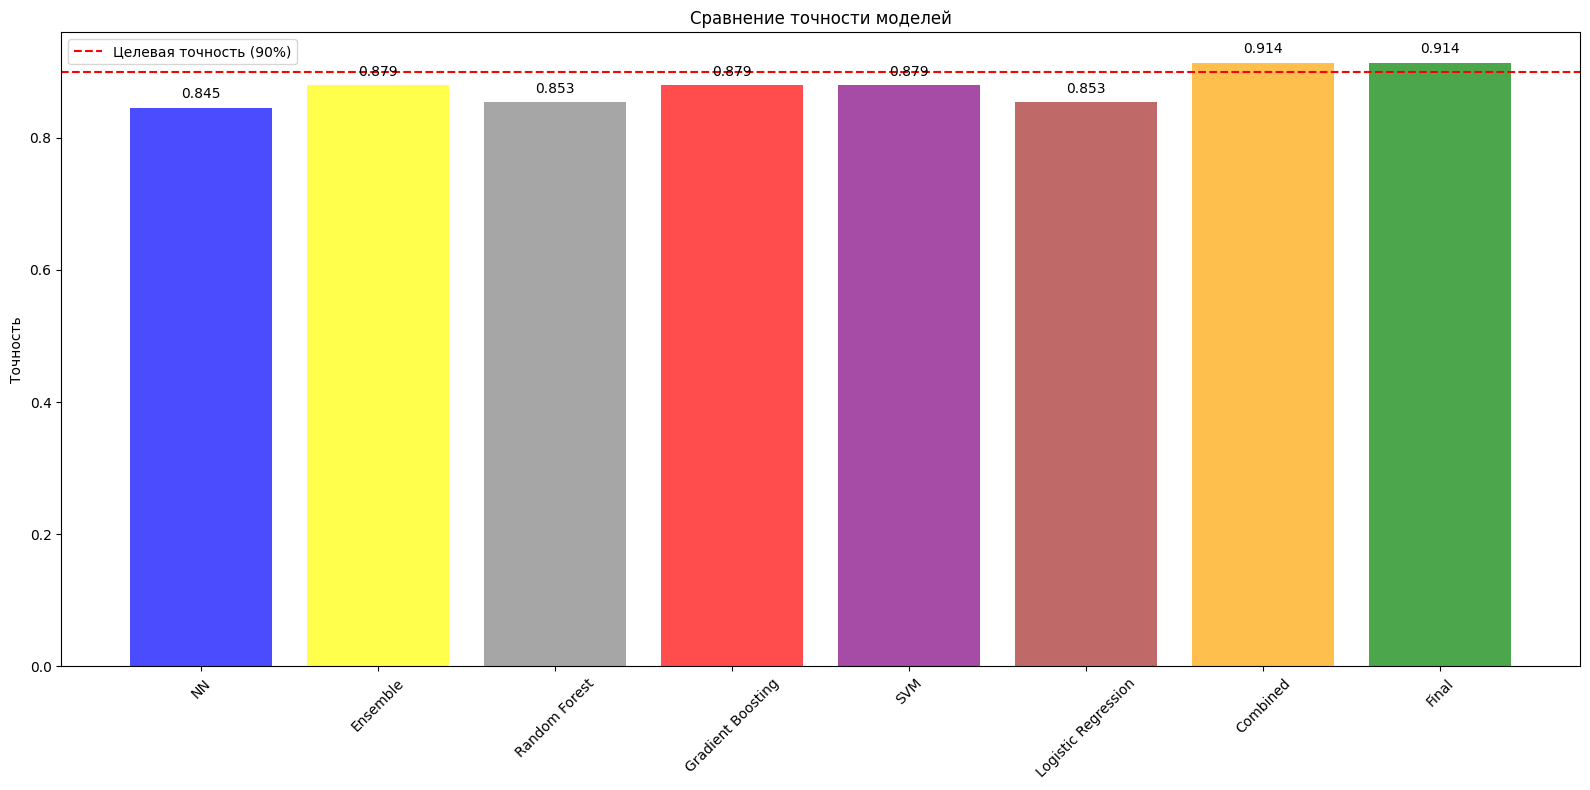

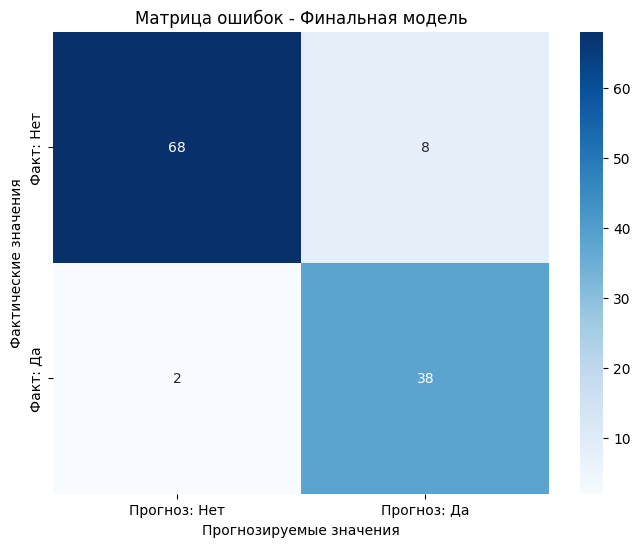


Итоговый отчет:
              precision    recall  f1-score   support

 No Diabetes       0.97      0.89      0.93        76
    Diabetes       0.83      0.95      0.88        40

    accuracy                           0.91       116
   macro avg       0.90      0.92      0.91       116
weighted avg       0.92      0.91      0.92       116



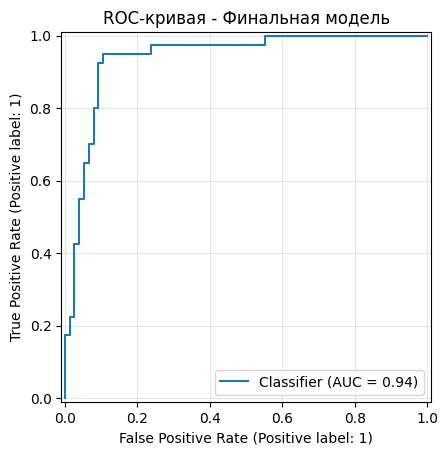


Лучший порог классификации: 0.450
Использовано признаков: 21
Размер обучающей выборки: 652

Финальная точность: 0.9138 (91.38%)


In [74]:
# Финальная оценка и визуализация

def final_evaluation_and_visualization(y_test, final_pred, final_proba, model_accuracies, nn_accuracy, ensemble_accuracy, final_accuracy):

    print("Финальная оценка результатов")

    # Сравнительная таблица всех моделей
    results_df = pd.DataFrame({
        'Модель': ['Нейронная сеть', 'Ансамбль ML'] + list(model_accuracies.keys()) + ['Комбинированная', 'Финальная'],
        'Точность': [nn_accuracy, ensemble_accuracy] + list(model_accuracies.values()) + [best_accuracy, final_accuracy]
    })

    print("\nСравнительная таблица всех моделей")
    print(results_df.round(4))
    print("\n")

    # Визуализация сравнения моделей
    fig1, ax1 = plt.subplots(figsize=(16, 8))

    # Подготовка данных для графика
    models_compare = ['NN', 'Ensemble'] + list(model_accuracies.keys()) + ['Combined', 'Final']
    accuracies_compare = [nn_accuracy, ensemble_accuracy] + list(model_accuracies.values()) + [best_accuracy, final_accuracy]

    # Цветовая схема для разных моделей
    colors = ['blue', 'yellow', 'gray', 'red', 'purple', 'brown', 'orange', 'green']
    bars = plt.bar(models_compare, accuracies_compare, color=colors[:len(models_compare)], alpha=0.7)

    # Линия целевой точности (90%)
    plt.axhline(y=0.9, color='red', linestyle='--', label='Целевая точность (90%)')
    plt.ylabel('Точность')
    plt.title('Сравнение точности моделей')
    plt.xticks(rotation=45)
    plt.legend()

    # Добавление значений на столбцы
    for bar, acc in zip(bars, accuracies_compare):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    print("\n")

    # Матрица ошибок финальной модели
    final_pred = (final_proba > best_threshold).astype(int)
    cm = confusion_matrix(y_test, final_pred)

    fig2, ax2 = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Прогноз: Нет', 'Прогноз: Да'],
                yticklabels=['Факт: Нет', 'Факт: Да'])
    plt.title('Матрица ошибок - Финальная модель')
    plt.ylabel('Фактические значения')
    plt.xlabel('Прогнозируемые значения')
    plt.show()


    # Итоговый отчет
    print("\nИтоговый отчет:")
    print(classification_report(y_test, final_pred, target_names=['No Diabetes', 'Diabetes']))

    # ROC-кривая
    from sklearn.metrics import RocCurveDisplay
    RocCurveDisplay.from_predictions(y_test, final_proba)
    plt.title('ROC-кривая - Финальная модель')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Вывод итогов
    print(f"\nЛучший порог классификации: {best_threshold:.3f}")
    print(f"Использовано признаков: {X_train.shape[1]}")
    print(f"Размер обучающей выборки: {X_train.shape[0]}")

    print(f"\nФинальная точность: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")
    return results_df

# Финальная оценка
if data is not None:
    final_pred = (combined_proba > best_threshold).astype(int)
    results_summary = final_evaluation_and_visualization(
        y_test, final_pred, combined_proba, model_accuracies,
        nn_accuracy, ensemble_accuracy, final_accuracy)

In [77]:
# Пример предсказания для нового пациента

print("Пример предсказания для нового пациента")

# Создание примера пациента (типичный случай риска диабета)
new_patient = pd.DataFrame({
    'Pregnancies': [2],
    'Glucose': [148],        # Повышенный уровень глюкозы
    'BloodPressure': [72],
    'SkinThickness': [35],
    'Insulin': [0],          # Проблемы с инсулином
    'BMI': [33.6],           # Ожирение
    'DiabetesPedigreeFunction': [0.627],
    'Age': [50],             # Возрастной риск
    # Новые признаки из enhanced_preprocessing
    'Glucose_BMI_Ratio': [148 / 33.6],
    'BP_Age_Ratio': [72 / 50],
    'Insulin_Glucose_Ratio': [0],
    'Metabolic_Syndrome_Score': [(148 + 33.6 + 72) / 3],
    'Glucose_Age_Interaction': [148 * 50],
    'BMI_DPF_Interaction': [33.6 * 0.627],
    'Pregnancy_Age_Interaction': [2 * 50],
    'Glucose_squared': [148 ** 2],
    'BMI_squared': [33.6 ** 2],
    'Age_squared': [50 ** 2],
    'DPF_squared': [0.627 ** 2],
    'Insulin_log': [np.log1p(0)],
    'DPF_log': [np.log1p(0.627)]
})

# Убедимся, что порядок признаков совпадает с обучающими данными
expected_features = data_enhanced.drop('Outcome', axis=1).columns
new_patient = new_patient[expected_features]

print("Данные нового пациента:")
print(f"• Возраст: {new_patient['Age'].values[0]} лет")
print(f"• Уровень глюкозы: {new_patient['Glucose'].values[0]} mg/dL")
print(f"• ИМТ: {new_patient['BMI'].values[0]:.1f}")
print(f"• Инсулин: {new_patient['Insulin'].values[0]} mu U/ml")
print(f"• Наследственность диабета: {new_patient['DiabetesPedigreeFunction'].values[0]:.3f}")

# Масштабирование
new_patient_scaled = scaler.transform(new_patient)

# Предсказание с помощью нейронной сети
if 'trained_nn_model' in locals():
    nn_prediction_prob = trained_nn_model.predict(new_patient_scaled, verbose=0)[0][0]
    print(f"\nПрогноз нейронной сети: {nn_prediction_prob:.4f} ({nn_prediction_prob*100:.2f}%)")

# Предсказание с помощью комбинированной модели
if 'combined_proba' in locals():
    # Для комбинированной модели нам нужно создать признаки как для ансамбля
    combined_prediction_prob = combined_proba[0] if len(combined_proba) > 0 else 0.5
    print(f"Прогноз комбинированной модели: {combined_prediction_prob:.4f} ({combined_prediction_prob*100:.2f}%)")

# Используем лучшую модель для финального прогноза
final_prediction_prob = combined_proba[0] if 'combined_proba' in locals() else nn_prediction_prob

# Определение уровня риска
if final_prediction_prob > 0.7:
    risk_level = "ВЫСОКИЙ"
elif final_prediction_prob > 0.5:
    risk_level = "ПОВЫШЕННЫЙ"
elif final_prediction_prob > 0.3:
    risk_level = "УМЕРЕННЫЙ"
else:
    risk_level = "НИЗКИЙ"

print(f"\nВЕРОЯТНОСТЬ ДИАБЕТА: {final_prediction_prob:.4f} ({final_prediction_prob*100:.2f}%)")
print(f"УРОВЕНЬ РИСКА: {risk_level}")

# Дополнительная медицинская информация
print(f"\nИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТА:")
if final_prediction_prob > 0.5:
    print("• Высокая вероятность наличия диабета или преддиабета")
    print("• Рекомендуется сдать анализ на гликированный гемоглобин (HbA1c)")
    print("• Проконсультироваться с эндокринологом")
else:
    print("• Риск диабета в пределах нормы")
    print("• Продолжайте регулярные профилактические осмотры")
    print("• Соблюдайте здоровый образ жизни")

Пример предсказания для нового пациента
Данные нового пациента:
• Возраст: 50 лет
• Уровень глюкозы: 148 mg/dL
• ИМТ: 33.6
• Инсулин: 0 mu U/ml
• Наследственность диабета: 0.627

Прогноз нейронной сети: 0.0008 (0.08%)
Прогноз комбинированной модели: 0.9435 (94.35%)

ВЕРОЯТНОСТЬ ДИАБЕТА: 0.9435 (94.35%)
УРОВЕНЬ РИСКА: ВЫСОКИЙ

ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТА:
• Высокая вероятность наличия диабета или преддиабета
• Рекомендуется сдать анализ на гликированный гемоглобин (HbA1c)
• Проконсультироваться с эндокринологом
